# Sea ice thickness retrieval implementation
## Introduction
The retrieval uses the fitted parameters from individual fits of ice thickness to brightness temperatures and a minimization scheme including uncertainties using the error covariance matrix of $T_{b,h}$ and $T_{b_v} at 1.4 GHz. In contrast to the original Huntemann et al. 2014 retrieval, the upper limit is not determined capped but left open, very loosely constrained by a background ice thickness. For comparison the original fit parameters from Huntemann et al. 2014 in the lastest version are used for comparison and evaluation. However, the original parameters where obtained for an incidence angle range from 40° to 50° while the new fit parameters were obtained to match the CIMR incidence angle of 53°. The equations used for their fits are 

$$\begin{eqnarray}
I_p(x)= p_2 - (p_2 - p_1)\exp(-x/p_3) \label{eq:intensity} \tag{1} \\
Q_p(x)= p_2- (p_2 - p_1)\exp(-x/p_3)^{p_4} \label{eq:poldiff} \tag{2}
\end{eqnarray}$$

with $I=(T_{b,v}+T_{b,h})/2$ being the Intensity and $Q=T_{b,v}-T_{b,h}$, and $p$ as the fit parameters. Note that equation \eqref{eq:intensity} is the same as the one used for fitting the individual polarization components to the ice thickness.


In [320]:
using Pkg
Pkg.activate("../sit_atbd_env_jl")
using Plots
using LaTeXStrings
using Optim
using ForwardDiff
using YAML
using Markdown
using Printf

  Activating project at `~/SeaIceThickness_ATBD/sit_atbd_env_jl`


In [321]:
I(p)=f(x)=p[2]-(p[2]-p[1])*exp(-x/p[3])
Q(p)=f(x)=p[2]-(p[2]-p[1])*exp(-(x/p[3])^p[4])

#fit params I,Q original lastest, retrieval base from Huntemann et al., 2014, Paţilea et al., 2019
pI=(108.3,232.2,13.4)
pQ=(81.2,33.8,33.7,1.64)
fI(x)=I(pI)(x)

fQ(x)=Q(pQ)(x)

#reading fit parameters from file
params=YAML.load_file("fit_params.yml")
tbh_params,tbv_params=getindex.(Ref(params),["ph","pv"])


ff(p)=x->p[2]-(p[2]-p[1])*exp(-x/p[3])
sit_h=ff(tbh_params)
sit_v=ff(tbv_params)


#373 (generic function with 1 method)

In [323]:
t(n)=@sprintf "%.2f" n

md"""
The fit parameters are 

| quantity\parameter | $p_1$ | $p_2$ | $p_3$ | $p_4$ |
| --- | --- | --- | --- | --- |
| Intensity $I$ | $(t(pI[1])) | $(t(pI[2])) | $(t(pI[3])) | |
| polarization difference $Q$ | $(t(pQ[1])) | $(t(pQ[2])) | $(t(pQ[3])) | $(t(pQ[4])) |
"""

The fit parameters are 

|          quantity\parameter |  $p_1$ |  $p_2$ | $p_3$ | $p_4$ |
| ---------------------------:| ------:| ------:| -----:| -----:|
|               Intensity $I$ | 108.30 | 232.20 | 13.40 |       |
| polarization difference $Q$ |  81.20 |  33.80 | 33.70 |  1.64 |


## retrieval definition
The retrieval is following a typical scheme with the objective to minimize
$$\begin{equation}
χ^2(\mathbf y,\mathbf x,\mathbf S_e,\mathbf S_a,\mathbf x_a)=\left(\mathbf y-F(\mathbf x)\right)^\mathbf{T}\mathbf S_e^{-1}(\mathbf y-F(\mathbf x))+(\mathbf x_a-\mathbf x)^{\mathbf T}\mathbf S_a^{-1}(\mathbf x_a - \mathbf x) \label{eq:chi2} \tag{3},
\end{equation}
$$
where $\mathbf y= \begin{bmatrix}T_{b,h}\\T_{b,v}\end{bmatrix}$ is the vector of input (measured) brightness temperatures, $\mathbf x$ is the result vector (in case of the retrieval of only one quantity, ice thickness, this is a scalar),  $\mathbf S_e$ is the error covariance matrix of the input brightness temperatures, $\mathbf S_a$ is the covariance matrix of the background values (in this case a scalar), $\textbf x_a$ is the background value (ice thickness) and $F$ is the forward operator, in our caes the individual fit function for a given ice thickness, i.e., 
$F(\mathbf x) = \begin{bmatrix}f_h(\mathbf x)\\ f_v(\mathbf x)\end{bmatrix}$

The optimal solution $\hat {\mathbf y}$ which minimizes equation \eqref{eq:chi2} is found by iteration. 
The uncertainty of $\mathbf y$ can then be obtained as 
$$
\begin{equation}
\hat {\mathbf S}_a= (\mathbf S_a^{-1}+\mathbf M^\mathbf T \mathbf S_e^{-1}\mathbf M)^{-1}, \label{eq:erorr} \tag{4}
\end{equation}
$$
which is in this case also a scalar. $\

Some variables are fixed in this scheme, this is the background ice thickness $\mathbf x_a=x_a=100$ cm and its variance $\mathbf S_a=S_a=20000\ cm^2$ which is practically used to very loosly contrain the ice thickness. Others parameters are obtained from the CIMR satellite like $\mathbf y= \begin{bmatrix}T_{b,h}\\T_{b,v}\end{bmatrix}$ and the diagonal components of the covariance matrix $\mathbf S_a$, for the offdiagonal of $\mathbf S_a$ there is no good estimate, but it is not expected that the uncertainties of $T_{b,h}$ and $T_{b,v}$ are uncorrelated. For the lack of a better estimate, we claim a correlation of 0.6 which results in off diagonal elements of $0.6*\sigma_{Tbh}\sigma_{TBv}$. for illustration of the algorithm we use 
$$
\begin{equation}
\mathbf S_a = \begin{bmatrix}25 & 15\\ 15 & 25\end{bmatrix}\label{eq:tberror} \tag{5}
\end{equation}
$$


In [334]:
function retrieval(Ta,Se,Sa,xa,F)
    # easy retrieval method
    # Ta is a vector of length of input for one single retrieval length N
    # Se is the error covariance matrix of the input, i.e. length N x N
    # Sa is the error covariance matrix of the output, i.e. length M x M (the error of the background value)
    # xa is a background value where Sa is the error of, i.e. a vector of length M
    # F is a forward model receiving a input vector of length N and return an output of length M
    # ymin and ymax are the limits of the oupt regime where ot search in, both are of length M
    # returns Y, the output vector
    
    #defining error function to menimize as χ² 
    χ²(y,x,Se)=(y.-F(x))'*(Se\(y.-F(x)))
    χ²(y,x,Se,Sa,xa)=χ²(y,x,Se)+(xa.-x)'*(Sa\(xa.-x))
   if length(xa)==0
        y=[maximize(y->-χ²(Ta,y,Se,Sa,xa),0,10000).res.minimizer]
    else
        res=optimize(y->χ²(Ta,y,Se,Sa,xa),xa)
        y=res.minimizer
    end
    
    M=ForwardDiff.jacobian(F,y)
    yerr=inv(inv(Sa)+M'*inv(Se)*M)
    return y,yerr
end
    
Fw_TB(x)=[sit_h(x[1]), sit_v(x[1])]
Fw_IQ(x)=[fI(x[1]), fQ(x[1])]

c=15
retrieval(h,v)=retrieval([h,v],[25 c;c 25.0],fill(20000.,1,1),[100.],Fw_TB)


retrieval (generic function with 2 methods)

The comparison will be done with a least squares fit based $I$-$Q$-retrieval from Huntemann et al. 2014, i.e., the cost function is 

$$
\begin{equation}
c(x)=(I(x)-I_m)^2+(Q(x)-Q_m)^2 \label{eq:IQcost} \tag{6}
\end{equation}
$$
which is minimized to obtain the best ice thickness $x$

In [336]:
cost(II,QQ)=f(x)=(fI(x)-II)^2+(fQ(x)-QQ)^2
retrieval_hun(ii,qq)=maximize(x->-cost(ii,qq)(x),0,200).res.minimizer 


retrieval_hun (generic function with 1 method)

In [337]:
Qs=20:90
Is=100:270
out=[retrieval_hun(ii,qq) for ii=Is,qq=Qs];
out_orig=[retrieval(ii-qq/2,ii+qq/2)[1][1] for ii=Is,qq=Qs];

In [338]:
cfdd(temp,duration)=1.33*(-(temp+1.8)*duration)^0.58
dcfdd(temp,duration)=1.33*0.58*(-(temp+1.8))/((-(temp+1.8)*duration)^0.42)

dcfdd (generic function with 1 method)

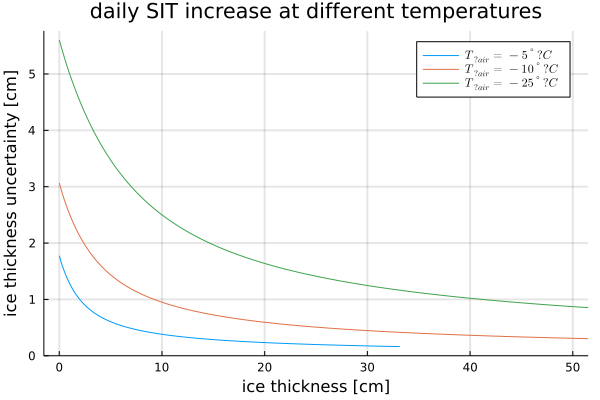

In [339]:
days=0:0.01:80

max_ig(T,t)=cfdd(T,t+1)-cfdd(T,t-0)
sittime(sit,temp)=(1/(sit*1.33*(-temp+1.8)))^(1/0.58)
plot(gridlinewidth=2)
for temp in [-5,-10,-25]    
    plot!(cfdd.(temp,days),max_ig.((temp,),days)*0.68,label=latexstring("T_{\\mbox{air}} = $temp ^\\circ \\mbox{C}"))
end
xlims!(-1.5,51.5)
title!(("daily SIT increase at different temperatures"))
xlabel!("ice thickness [cm]")
ylabel!("ice thickness uncertainty [cm]")

In [330]:
function owmix(x,owf)
    owtbh=65
    owtbv=155
    owi=owtbv/2+owtbh/2
    owq=owtbv-owtbh
    IR=fI(x)
    QR=fQ(x)
    I=IR*(1-owf)+owi*owf
    Q=QR*(1-owf)+owq*owf
    retrieval_hun(I,Q)
end
#owmix

owerr(x)=((x-owmix(x,-0.05))^2+(x-owmix(x,0.05))^2)^0.5


function owerr_2(x)
    tbh,tbv=Fw_TB(x)
    owtbh=72
    owtbv=147
    owf=-0.05
    ntbh=(tbh*(1-owf)+(owtbh*owf))
    ntbv=(tbv*(1-owf)+(owtbv*owf))
    owf=0.05
    sit_minus=retrieval(ntbh,ntbv)[1][1]
    ntbh=(tbh*(1-owf)+(owtbh*owf))
    ntbv=(tbv*(1-owf)+(owtbv*owf))
    sit_plus=retrieval(ntbh,ntbv)[1][1]
    return ((x-sit_plus)^2+(x-sit_minus)^2)^0.5
#    return sit_plus,sit_minus
end

function retrerr(x,ra)
    IR=fI(x)
    QR=fQ(x)
    ixmax=retrieval_hun(IR+ra*sqrt(2)/2,QR)
    ixmin=retrieval_hun(IR-ra*sqrt(2)/2,QR)
    qxmax=retrieval_hun(IR,QR+ra*sqrt(2))
    qxmin=retrieval_hun(IR,QR-ra*sqrt(2))
    #mean((x.-[ixmax,ixmin,qxmax,qxmin]).^2)^0.5
    (maximum(x.-[ixmax,ixmin])^2+maximum(x.-[qxmax,qxmin])^2)^0.5
end

sittime(sit,temp)=-(sit/1.33)^(1/0.58)/(temp+1.8)

function cfdd_unc(sit)
    t=sittime(sit,-25)
    return (cfdd(-25,t+1)-cfdd(-25,t))*0.68
end

    #retrieval(IR*)
#plot(owmix.(0:50,-0.05).-owmix.(0:50,0.0))
#plot!(owmix.(0:50,0.0)-owmix.(0:50, 0.05))

    #(owmix.(0:200,0.05))
function comb_error(sit)
    return sqrt(cfdd_unc(sit)^2+retrerr(sit,5)^2+owerr(sit)^2)
end

function comb_error_2(sit)
    return sqrt(cfdd_unc(sit)^2+retrieval(Fw_TB(sit),[25 c;c 25.0],fill(20000.,1,1),[100.],Fw_TB)[2][1]+owerr_2(sit)^2)
end

comb_error_2 (generic function with 1 method)

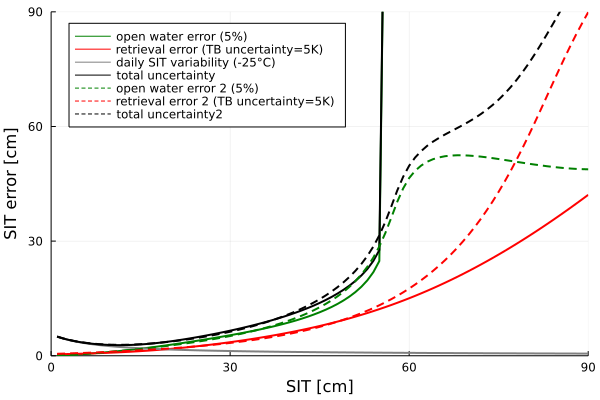

In [331]:
sit=1:90
plot(sit,owerr.(sit),label="open water error (5%)",lw=2,c=:green)
plot!(sit,retrerr.(sit,(5,)),label="retrieval error (TB uncertainty=5K)",lw=2,c=:red)
plot!(sit,cfdd_unc.(sit),label="daily SIT variability (-25°C)",lw=2,c=:gray)

#plot!(sit,errf.(sit),label="fw model SIT err",lw=2)

plot!(sit,comb_error.(sit),label="total uncertainty",lw=2,legend=:topleft,c=:black)

plot!(sit,owerr_2.(sit),label="open water error 2 (5%)",lw=2,ls=:dash,c=:green)
plot!(sit,[retrieval(Fw_TB(s)...)[2][1]^0.5 for s in sit],label="retrieval error 2 (TB uncertainty=5K)",lw=2,ls=:dash,c=:red)
plot!(sit,comb_error_2.(sit),label="total uncertainty2",lw=2,ls=:dash,legend=:topleft,c=:black)

xlims!(0,90)
ylims!(0,90)
xlabel!("SIT [cm]")
ylabel!("SIT error [cm]",dpi=200)
#savefig("/home/huntemann/Seafile/myHome/CIMR_errors.png")


In [251]:
sqrt(20000)

141.4213562373095

In [252]:
Qs=20:90
Is=100:270
#out=[retrieval3(ii-qq/2,ii+qq/2)*100 for ii=Is,qq=Qs];
out=[retrieval(ii-qq/2,ii+qq/2)[1][1] for ii=Is,qq=Qs]
#out_unc=[retrieval3([ii-qq/2,ii+qq/2],[25 15;15 25.0],fill(1000,1,1),[50.],Fw_TB)[2][1] for ii=Is,qq=Qs]

out_orig=[retrieval_hun(ii,qq) for ii=Is,qq=Qs];

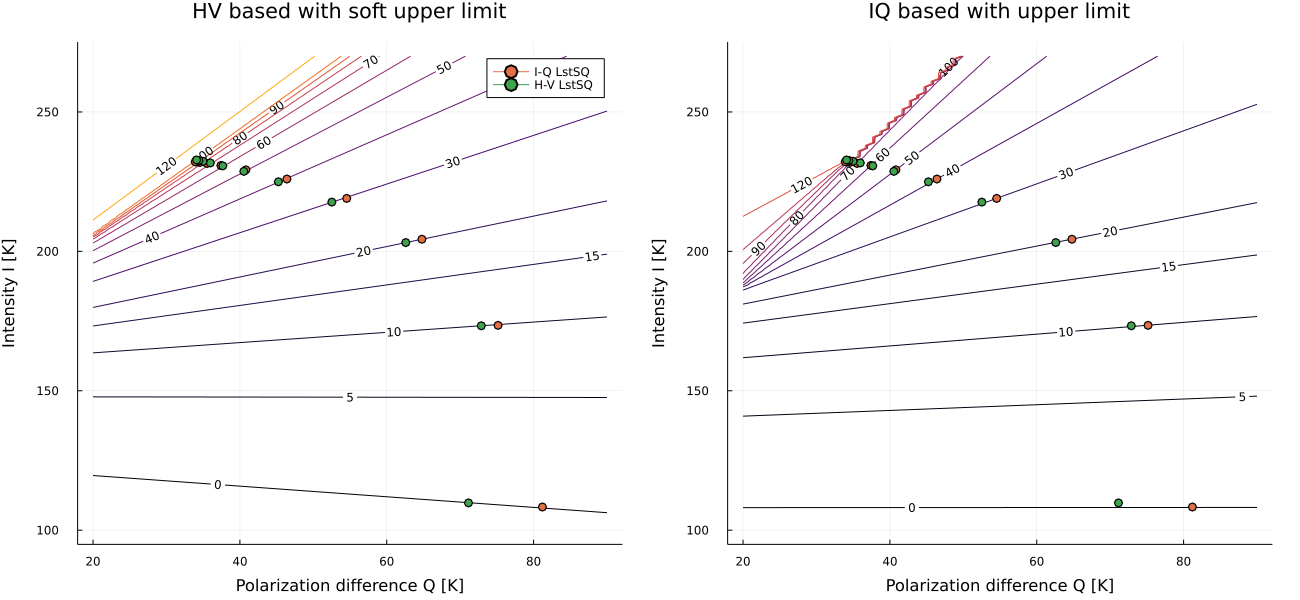

In [253]:
p1=contour(Qs,Is,out.-0.01,levels=[0,5,10,15,20,30,40,50,60,70,80,90,100,120],contour_labels=true,colorbar=false,dpi=150)
sit=0:10:100
h,v=sit_h.(sit),sit_v.(sit)
allq,alli=v.-h,h./2 .+v./2
plot!(fQ.(sit),fI.(sit),lw=0,m=:o,label="I-Q LstSQ")
plot!(allq,alli,lw=0,m=:o,label="H-V LstSQ")

xlabel!("Polarization difference Q [K]")
ylabel!("Intensity I [K]")

title!("HV based with soft upper limit")


p2=contour(Qs,Is,out_orig.-0.01,levels=[0,5,10,15,20,30,40,50,60,70,80,90,100,120],contour_labels=true,colorbar=false,dpi=150)
sit=0:10:100
plot!(fQ.(sit),fI.(sit),legend=false,lw=0,m=:o)
plot!(allq,alli,legend=false,lw=0,m=:o)
title!("IQ based with upper limit")

xlabel!("Polarization difference Q [K]")
ylabel!("Intensity I [K]")
plot(p1,p2,size=[1300,600],margin=5Plots.mm)

#savefig("retrieval_curve.png")

In [257]:
I_from_hv=(sit_h.(sit)+sit_v.(sit))/2
Q_from_hv=(sit_v.(sit)-sit_h.(sit))
sit_from_IQ=retrieval_hun.(I_from_hv,Q_from_hv)
sit_from_hv=[retrieval(fI(s)-fQ(s)/2,fI(s)+fQ(s)/2)[1][1] for s in sit];

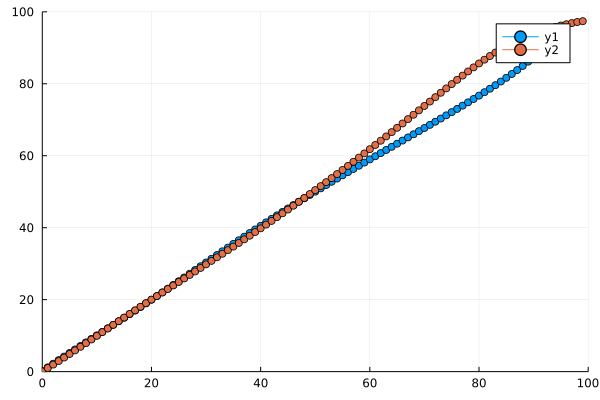

In [220]:
plot(sit,sit_from_IQ,m=:dot,lw=0)
plot!(sit,sit_from_hv,m=:dot,lw=0)
xlims!(0,100)
ylims!(0,100)

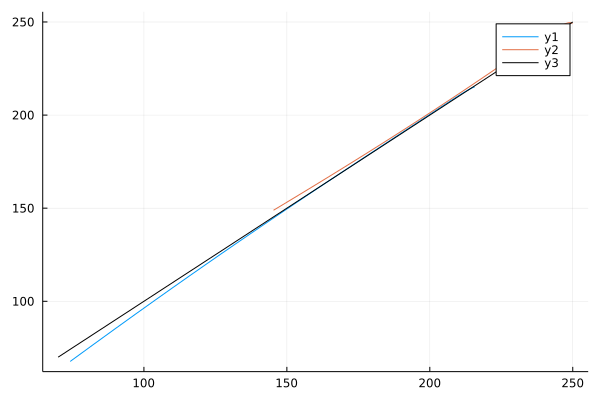

In [258]:
plot(sit_h.(sit),fI.(sit)-fQ.(sit)./2)
plot!(sit_v.(sit),fI.(sit)+fQ.(sit)./2)
plot!(70:250,70:250,color=:black)

In [259]:
Fw_TB(161)

2-element Vector{Float64}:
 216.12925561265422
 249.83035765117387

In [223]:
hh=70:260
vv=70:260
retr_res=[retrieval(h,v)[1][1] for h=hh,v=vv];

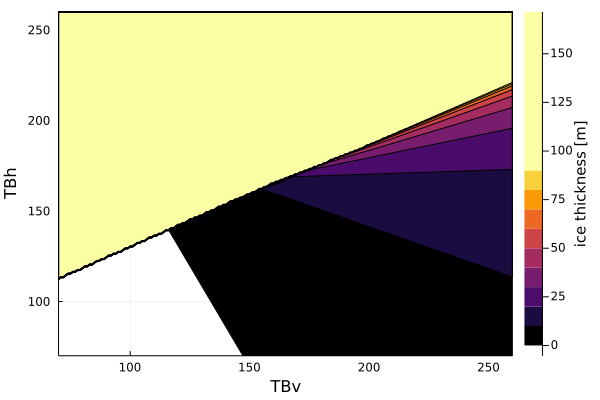

┌ Warning: GR: highest contour level less than maximal z value is not supported.
└ @ Plots /Users/huntemann/.julia/packages/Plots/E2187/src/backends/gr.jl:548


In [229]:
contourf(hh,vv,retr_res,levels=0:10:100,colorbar_title="ice thickness [m]")
h,v=210,240
#plot!([v],[h],marker=:o)
#@show retrieval3([h,v],[25 15;15 25.0],fill(10000,1,1),[50.],Fw_TB)[1][1]
xlabel!("TBv")
ylabel!("TBh")
